# Chosen distances for tevsimbad

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE


In [2]:
#metric_function = st.wasserstein_distance

In [3]:
metric_function = lambda x, y : np.sqrt(np.sum(np.multiply(x, y)))/max(np.sqrt(np.sum(np.multiply(x, x))*np.sum(np.multiply(y, y))),10**(-50))

In [4]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [5]:
#name columns included in the final display
other_names = ['s_MAIN_ID', 's_class',  'tev_fermi_names', 'tev_classes', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/tevsimbad_TeVspectrum_normalized.txt"

In [6]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,...,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,0.0,0.000000,0.000000,0.000060,0.000000,0.000143,0.001702,0.003243,0.007779,0.0,...,0.484812,0.272675,0.056902,0.037315,0.135368,b'UCAC4 105-013663',Be,b'',b'other',0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000338,0.019565,0.869940,0.0,...,0.045760,0.029010,0.025940,0.008455,0.000992,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.002454,0.616424,0.0,...,0.148664,0.120621,0.081368,0.027734,0.002726,b'SSTGC 519103',Be,b'',b'unid',0
3,0.0,0.027707,0.045983,0.000000,0.000000,0.000000,0.132615,0.170842,0.205397,0.0,...,0.003439,0.230194,0.136930,0.045784,0.001110,b'RMC 141',B,b'',b'pwn',0
4,0.0,0.000531,0.000618,0.000343,0.000474,0.000618,0.000385,0.000260,0.000244,0.0,...,0.489456,0.275287,0.057447,0.037672,0.136665,b'[AAA97b] J053648.7-691700',B,b'',b'other',0


In [7]:
spectrum_columns = spectra.columns[:-len(other_names)]

Computation of pairwise distances (metric - Earth mover's distance (Wasserstein distance))

In [8]:
if type(metric_function) == str:
    dist = DistanceMetric.get_metric(metric_function)
else:
    dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
spectra_distances = dist.pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)

Vizualization (mapping to 2D-plane)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


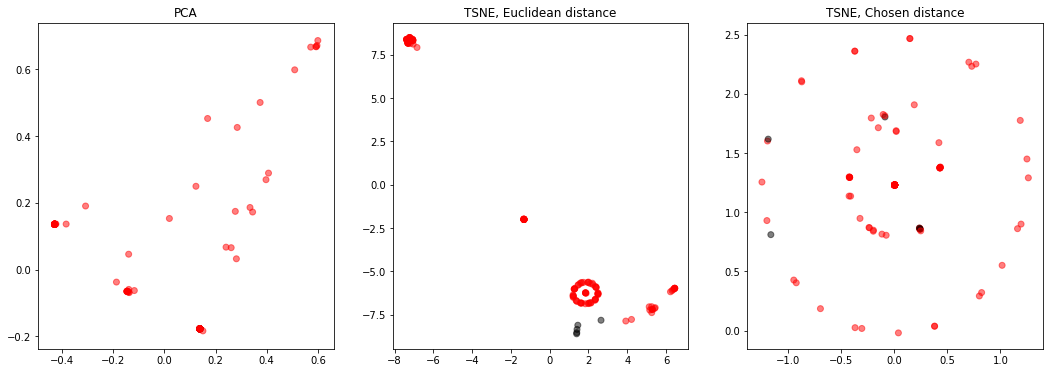

In [9]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, metric=metric_function, random_state=42)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

KMeans clustering (with Earth mover's distance metric)

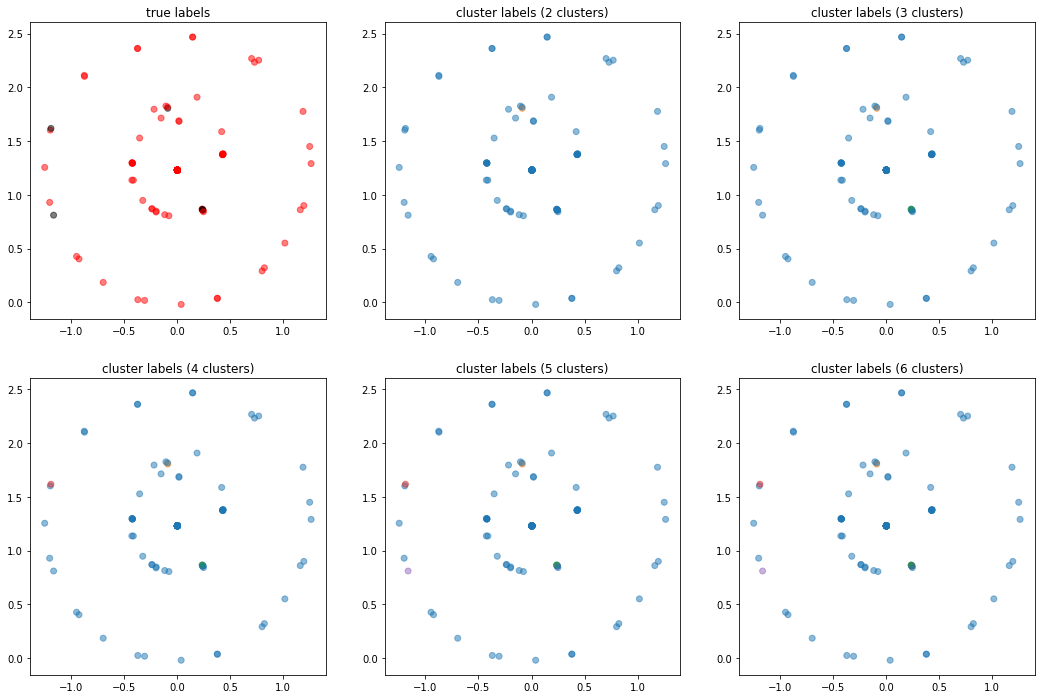

In [10]:
# visualization - tsne with Earth mover's distance
tsne = TSNE(n_components=2, metric=metric_function, random_state=42)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

plt.subplots(figsize=(18, 12))
plt.subplot(2, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for n in range(2, 7):
    kmeans = cluster.KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(spectra_distances)

    plt.subplot(2, 3, n)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels ({} clusters)".format(n))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
    
plt.show()

In [11]:
n = 6

kmeans = cluster.KMeans(n_clusters=n, random_state=42)
cluster_labels = kmeans.fit_predict(spectra_distances)

spectra['KMeans_clusters_' + str(n)] = cluster_labels
for i in range(n):
    print("{} cluster".format(i))
    display(spectra[spectra['KMeans_clusters_' + str(n)] == i][other_names])

0 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
2,b'SSTGC 519103',Be,b'',b'unid',0
3,b'RMC 141',B,b'',b'pwn',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
6,b'[ST92] 2-62B',B,b'',b'other',0
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
8,b'[ST92] 2-62',B,b'',b'other',0
9,b'HTR 13',B,b'',b'pwn',0


1 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
91,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856',b'bin',1


2 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
114,b'V* V479 Sct',B0Ve,b'',b'bin',1


3 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
59,b'LS I +61 303',B0Ve,b'',b'bin',1


4 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
60,b'HD 259440',B0Ve,b'',b'bin',1


5 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
74,b'CPD-63 2495',B0Ve,b'',b'bin',1
